In [2]:
import json
import os
import re
import time

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

import tensorflow as tf
print("TensorFlow version: {}".format(tf.VERSION))

import tflearn

//anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
//anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.7.0
Instructions for updating:
Use the retry module or similar alternatives.


# Load Data

In [3]:
game_state_dir = '/Users/lpekelis/flare/flare-ai/log/'
os.listdir(game_state_dir)

['.DS_Store',
 'GAME_STATES_2018-05-20_04_26_55%8AZ%FF\x7f',
 'GAME_STATES_2018-05-28_01_22_30TX%FF\x7f']

In [4]:
data = []
for fname in os.listdir(game_state_dir):
    if 'GAME_STATES' in fname:
        display(fname)
        with open(game_state_dir + fname) as f:
            for line in f:
                data.append(json.loads(line))

'GAME_STATES_2018-05-20_04_26_55%8AZ%FF\x7f'

'GAME_STATES_2018-05-28_01_22_30TX%FF\x7f'

In [5]:
display(
    len(data),
    data[0]
)

13588

{'e0->stats.alive': '1',
 'e0->stats.cur_state': '0',
 'e0->stats.hero_ally': '0',
 'e0->stats.hp': '50',
 'e0->stats.mp': '0',
 'e0->stats.pos.x': '83.500000',
 'e0->stats.pos.y': '18.500000',
 'e1->stats.alive': '1',
 'e1->stats.cur_state': '0',
 'e1->stats.hero_ally': '0',
 'e1->stats.hp': '50',
 'e1->stats.mp': '0',
 'e1->stats.pos.x': '54.500000',
 'e1->stats.pos.y': '14.500000',
 'e10->stats.alive': '1',
 'e10->stats.cur_state': '0',
 'e10->stats.hero_ally': '0',
 'e10->stats.hp': '50',
 'e10->stats.mp': '0',
 'e10->stats.pos.x': '15.500000',
 'e10->stats.pos.y': '51.500000',
 'e11->stats.alive': '1',
 'e11->stats.cur_state': '0',
 'e11->stats.hero_ally': '0',
 'e11->stats.hp': '50',
 'e11->stats.mp': '0',
 'e11->stats.pos.x': '12.500000',
 'e11->stats.pos.y': '87.500000',
 'e12->stats.alive': '1',
 'e12->stats.cur_state': '0',
 'e12->stats.hero_ally': '0',
 'e12->stats.hp': '50',
 'e12->stats.mp': '0',
 'e12->stats.pos.x': '69.500000',
 'e12->stats.pos.y': '65.500000',
 'e2->sta

In [6]:
map_path = '/Users/lpekelis/flare/flare-game/mods/flare_ai/maps/testing_grounds.txt'

map_dimensions = [100,100]
collision_layer = []
is_collision_layer = False

with open(map_path) as f:
    for line in f:
        if ( ('[layer]' in line) and ('type=collision' in next(f, '')) ):
            line = next(f, '')
            line = next(f, '')
            is_collision_layer = True
        if is_collision_layer:
            if line == '\n':
                is_collision_layer = False
            else:
                collision_layer.append(line.split(','))

In [9]:
display(
    len(collision_layer)
)

collision_layer_flat = [item for sublist in collision_layer for item in sublist]

100

# Featureize

In [10]:
def num_enemies(state):
    n = 0
    for key in state.keys():
        match = re.search('^e(\d+)',key)
        if match:
            n = max(n, int(match.group(1)))
    return n

num_enemies(data[0])

12

In [89]:
# added as map overlay across enemies
features_to_map = ['stats.hp']

# added for each enemy directly
features_self = ['stats.hp','stats.mp','stats.pos.x','stats.pos.y']

# player character features, distance pc to enemy always added
features_pc = ['stats.hp','stats.mp']

# entities can featurize all objects within a square region of their position
vision_dimensions = [20,20]

def dist_entities(c1,c2,state):
    # Example:
    # dist_entities('e0','pc',state)
    # signed distance assumes origin at upper left corner
    return (
        float(state[c2 + '->stats.pos.x']) - float(state[c1 + '->stats.pos.x']),
        float(state[c2 + '->stats.pos.y']) - float(state[c1 + '->stats.pos.y'])
    )

def flat_pos(x,y,map_dimensions):
    # Return position in flattened vector from 2d map
    
    return int(max(min(np.floor(y) * map_dimensions[0] + np.floor(x), np.prod(map_dimensions)), 0))

def add_feature_to_relative_overlay(e1, e2, feature_name, state, overlay, overlay_dimensions):
    # overlay is assumed relative to e1
    # e.g. a 10x10 grid centered at e1 location
    
    dx, dy = dist_entities(e1, e2, state)
    
    pos = np.array(overlay_dimensions)/2 + np.array([dx,dy])
    
    if np.logical_and(pos >= 0, pos <= overlay_dimensions).all():
        o_idx = flat_pos(pos[0],pos[1],overlay_dimensions)
        overlay[o_idx] = state['%s->%s' % (e2,feature_name)]
    
    # for debugging
    return pos

def X_from_state(state, n_e = None):
    if not n_e:
        n_e = num_enemies(state)
    
    X = {}
    for i in range(0, n_e+1):
        row = []
        for f in features_self:
            row.append(state['e%d->%s' % (i,f)])
        
        for f in features_pc:
            row.append(state['pc->%s' % f])
        
        # distance to pc always added
        dx, dy = dist_entities('e%d' % i, 'pc', state)
        row = row + [dx,dy]
        
        # TODO(Leo): add overlay features
        
        # allies hp
        allies_hp_overlay = [0] * (vision_dimensions[0] * vision_dimensions[1])
        
        for j in range(0, n_e+1):
            if j is not i:
                add_feature_to_relative_overlay('e%d' % i, 
                                                'e%d' % j, 
                                                'stats.hp',
                                                state,
                                                allies_hp_overlay,
                                                vision_dimensions)
        row = row + allies_hp_overlay
        
        # add copy of row to data matrix
        X[i] = list(row)
    
    X = pd.DataFrame.from_dict(X, orient='index').rename_axis('entity').apply(pd.to_numeric)
    
    X.columns = (
        ['e.' + f for f in features_self] 
        + ['pc.' + f for f in features_pc] 
        + ['e.pc.dx','e.pc.dy']
        + ['o_hp_%i' % i for i in range(np.prod(vision_dimensions))]
    )
    
    return X

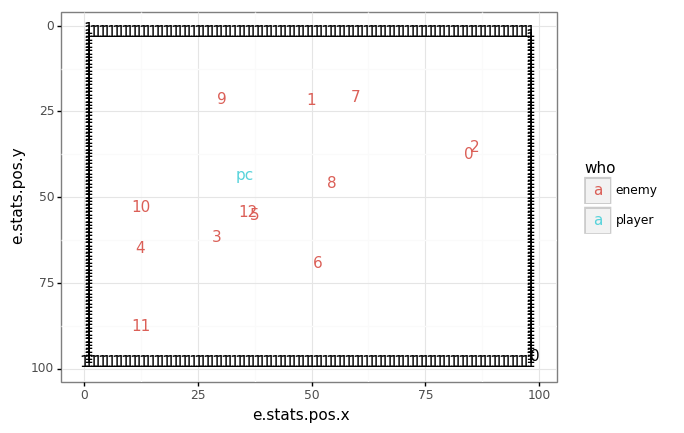

<ggplot: (-9223372036532743406)>

In [90]:
state = data[3000]
plot_state(state,[collision_layer],['black'])

In [93]:
pd.options.display.max_rows = 999
display(X_from_state(state).T)
pd.reset_option('display.max_rows')

entity,0,1,2,3,4,5,6,7,8,9,10,11,12
e.stats.hp,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000,50.000000,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000
e.stats.mp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
e.stats.pos.x,84.562500,50.000000,85.875000,29.242474,12.295493,37.534306,51.339500,59.750000,54.437500,30.375000,12.481810,12.500000,36.040661
e.stats.pos.y,37.312500,21.812500,35.437500,61.708454,64.729683,55.241657,69.188774,20.812500,45.875000,21.500000,52.818192,87.500000,54.347569
pc.stats.hp,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
pc.stats.mp,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
e.pc.dx,-49.319557,-14.757057,-50.632057,6.000469,22.947450,-2.291363,-16.096557,-24.507057,-19.194557,4.867943,22.761133,22.742943,-0.797718
e.pc.dy,6.206940,21.706940,8.081940,-18.189014,-21.210243,-11.722217,-25.669334,22.706940,-2.355560,22.019440,-9.298752,-43.980560,-10.828129
o_hp_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
o_hp_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


AttributeError: 'function' object has no attribute 'max_rows'

In [28]:
def y_from_state(state, n_e = None):
    if not n_e:
        n_e = num_enemies(state)
    
    y = {}
    for i in range(0, n_e+1):
        row = [
            state['e%d->stats.alive' % i],
            state['e%d->stats.hp' % i],
            state['pc->stats.hp']
        ]
        
        y[i] = row
    
    # TODO(Leo): set index name
    y = pd.DataFrame.from_dict(y, orient='index').rename_axis('entity').apply(pd.to_numeric)
    
    y.columns = [
        'is_entity_alive',
        'entity_hp',
        'pc_hp'
    ]
    
    return y

In [29]:
display(y_from_state(state))

,is_entity_alive,entity_hp,pc_hp
entity,,,
0,1,50,90
1,1,50,90
2,1,50,90
3,1,50,90
4,1,50,90
5,1,50,90
6,1,50,90
7,1,50,90
8,1,50,90


In [30]:
diff_cols = ['entity_hp','pc_hp']

def time_to_diff(df, diff_col):
    return ( 
        df
        .assign(is_diff=lambda df: df[diff_col] != 0.0)
        .groupby('entity')
        .apply(
            lambda df: df
                .assign(is_diff_cum_sum=lambda df: np.cumsum(df.is_diff))
                # last diff period assumed incomplete
                .assign(
                    time_filtered=lambda df: 
                        np.where(df.is_diff_cum_sum < max(df.is_diff_cum_sum),df.time,np.nan)
                )
        )
        .groupby(['entity','is_diff_cum_sum'])
        ['time_filtered']
        .transform(lambda x: max(x) - x)
        # pandas does something weird here
        .reset_index()
        ['time_filtered']
    )

def yX_from_data(data):
    # data - list of dicts
    
    y = {}
    X = {}
    for i, state in enumerate(data):
        n_e = num_enemies(state)
        y[i] = y_from_state(state,n_e)
        X[i] = X_from_state(state,n_e)

    y = pd.concat(y, names=['time'])
    X = pd.concat(X, names=['time'])

    y2 = (
        y
        .join(
            y.groupby('entity')[diff_cols].diff().fillna(0),
            rsuffix='_diff'
        )
        .reset_index()
    )

    for f in diff_cols:
        y2['time_to_' + f + '_diff'] = time_to_diff(y2, f + '_diff')
        y2['time_above_median_' + f + '_diff'] = 1*(
            y2['time_to_' + f + '_diff'] > np.nanmedian(y2['time_to_' + f + '_diff'])
        )
    
    y2 = y2.set_index(['time','entity']).dropna()
    X = X.dropna()

    y2 = y2[y2.index.isin(X.index)]
    X = X[X.index.isin(y2.index)]

    return y2,X

In [31]:
start_time = time.time()
y,X = yX_from_data(data)

display(
    y.shape,
    X.shape,
    y.head(),
    y.tail(),
    X.head(),
    "--- %s minutes ---" % ((time.time() - start_time) / 60)
)

KeyboardInterrupt: 

In [12]:
y_entity_damage = y.assign(
    time_above_median_entity_hp_diff_1=lambda df: 1*(df.time_above_median_entity_hp_diff==1),
    time_above_median_entity_hp_diff_0=lambda df: 1*(df.time_above_median_entity_hp_diff==0)
)[['time_above_median_entity_hp_diff_1','time_above_median_entity_hp_diff_0']]

# Diagnostics

In [68]:
def layer_to_df(layer):
    df = []
    for i,row in enumerate(layer):
        for j,cell in enumerate(row):
            if cell not in ['0','\n']:
                df.append({'pos.x':i,'pos.y':j,'value':cell})
    return pd.DataFrame.from_records(df)

def plot_state(state, layers, colors):
    pos_df = pd.concat({
        'enemy':
            X_from_state(state)
            .reset_index()
            [['entity','e.stats.pos.x','e.stats.pos.y']],
        'player': pd.DataFrame.from_records({'entity':['pc'],
                   'e.stats.pos.x':[float(state['pc->stats.pos.x'])],
                   'e.stats.pos.y':[float(state['pc->stats.pos.y'])]
                  })
        }, names=['who']
    ).reset_index()
    
    p = (
        ggplot(pos_df) 
        + scale_y_reverse()
        + geom_text(aes(x='e.stats.pos.x',y='e.stats.pos.y',label='entity',color='who'))
        + theme_bw()
    )
    
    for i,layer in enumerate(layers):
        p = p + geom_text(
            aes(x='pos.x',y='pos.y',label='value'),
            data = layer_to_df(layer),
            color = colors[i]
        )
    
    return p

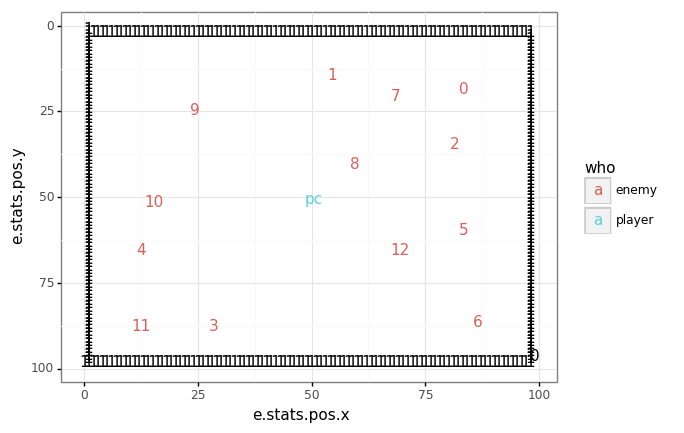

<ggplot: (304740458)>

In [14]:
plot_state(data[0], [collision_layer], ['black'])

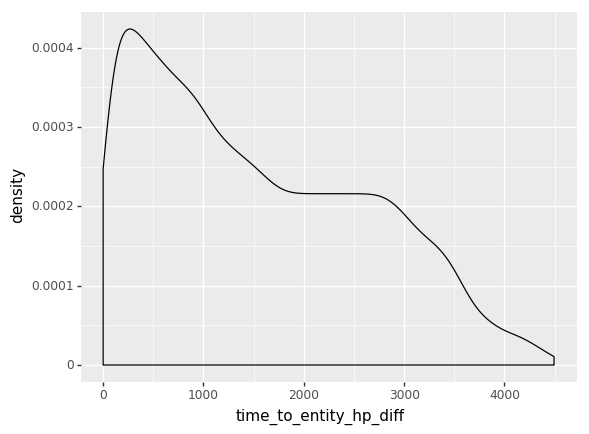

<ggplot: (-9223372036549264398)>

In [15]:
(
    ggplot(y.reset_index(), aes(x='time_to_entity_hp_diff')) 
    + geom_density()
)

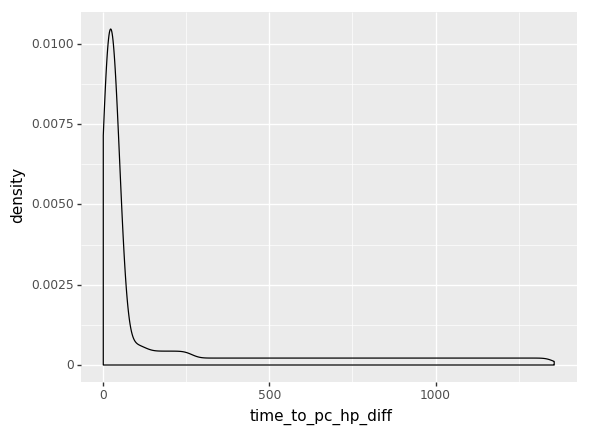

<ggplot: (-9223372036548840574)>

In [16]:
(
    ggplot(y.reset_index(), aes(x='time_to_pc_hp_diff')) 
    + geom_density()
)

# Fit model

In [17]:
display(
    X.shape,
    y_entity_damage.shape
)

(50930, 8)

(50930, 2)

In [18]:
# Build neural network
net = tflearn.input_data(shape=[None, 8])
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
# Define model
model = tflearn.DNN(net)
# Start training (apply gradient descent algorithm)
model.fit(
    np.array(X, dtype=np.float32), 
    np.array(y_entity_damage, dtype=np.float32), 
    n_epoch=10, 
    batch_size=16, 
    show_metric=True)

Training Step: 31839  | total loss: 0.68928 | time: 5.807s
| Adam | epoch: 010 | loss: 0.68928 - acc: 0.5319 -- iter: 50928/50930
Training Step: 31840  | total loss: 0.68921 | time: 5.809s
| Adam | epoch: 010 | loss: 0.68921 - acc: 0.5225 -- iter: 50930/50930
--


# Predict

In [22]:
pred = pd.DataFrame(
    model.predict(
        np.array(X, dtype=np.float32)
    )
)

In [28]:
pred.describe()

,0,1
count,50930.000000,50930.000000
mean,0.506414,0.493586
std,0.060335,0.060335
min,0.355455,0.373356
25%,0.461403,0.444710
50%,0.508734,0.491266
75%,0.555290,0.538597
max,0.626644,0.644545


In [37]:
min_idx = pred[0].idxmin()
max_idx = pred[0].idxmax()

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    30.241108
e.stats.pos.y    49.909042
pc.stats.hp       0.000000
pc.stats.mp      10.000000
e.pc.dx          -5.250355
e.pc.dy           2.364204
Name: (4629, 10), dtype: float64

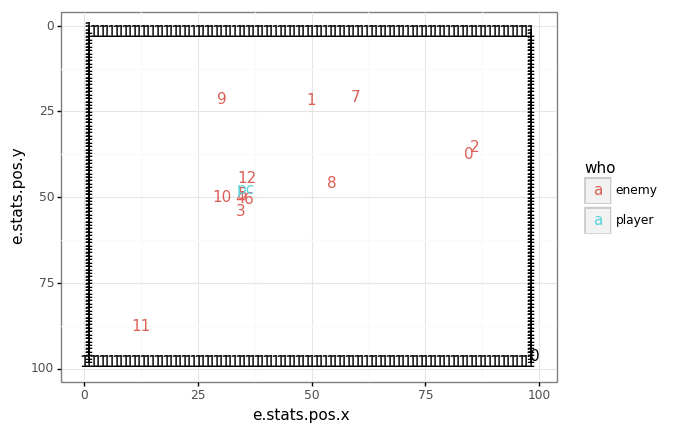

<ggplot: (305578851)>

In [42]:
display(X.iloc[min_idx,])
plot_state(data[X.index.values[min_idx][0]],[collision_layer],['black'])

e.stats.hp        0.000000
e.stats.mp        0.000000
e.stats.pos.x    54.437500
e.stats.pos.y    45.875000
pc.stats.hp      66.000000
pc.stats.mp      10.000000
e.pc.dx          22.978409
e.pc.dy          24.655682
Name: (613, 8), dtype: float64

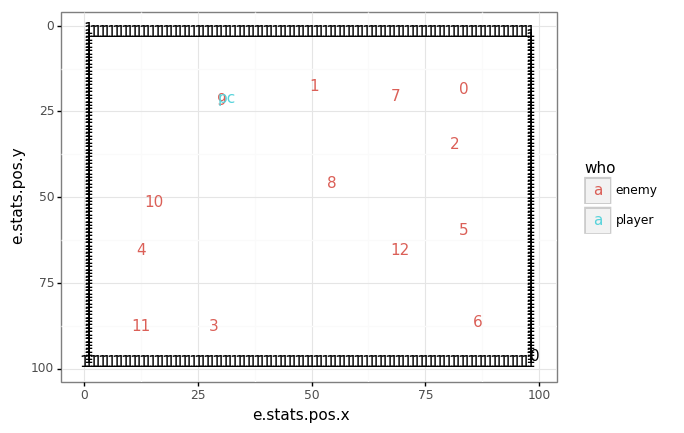

<ggplot: (-9223372036546838966)>

In [43]:
display(X.iloc[max_idx,])
plot_state(data[X.index.values[max_idx][0]],[collision_layer],['black'])

In [38]:
#temp = ['a','b','foobar','foo']
temp = ['a']
temp.pop(0)
np.any( ['foo' in x for x in temp] )

False